# Compositional analysis

Beyond changes in gene expression patterns, cell compositions, such as the proportions of cell-types, can change between conditions. A specific drug may, for example, induce a transdifferentiation of a cell type which will be reflected in the cell identity composition. Sufficient cell and sample numbers are required to accurately determine cell-identity cluster proportions and background variation. Compositional analysis can be done on the level of cell identity clusters in the form of known cell types or cell states corresponding to, for example, cells recently affected by perturbations. This chapter will introduce both approaches and apply them to the Haber dataset{cite}`Haber2017`.

This dataset contains 53,193 individual epithelial cells from the small intestine and organoids of mice. Some of the cells were also subject to bacterial or helminth infection such as through Salmonella and Heligmosomoides polygyrus respectively.
Throughout this tutorial we are using a subset of the complete Haber dataset which only includes control and infected cells that were collected specifically for this purpose. Notably, we are excluding an additional dataset which collected only large cells for faster computation and reduced complexity.

As a first step, we load the dataset.

## Data loading

In [1]:
import warnings

warnings.filterwarnings("ignore")

import scanpy as sc
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

In [3]:
adata = sc.read("haber_count.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 9842 × 15215
    obs: 'batch', 'barcode', 'condition', 'cell_label'

In [5]:
adata.obs

,batch,barcode,condition,cell_label
index,,,,
B1_AAACATACCACAAC_Control_Enterocyte.Progenitor,B1,AAACATACCACAAC,Control,Enterocyte.Progenitor
B1_AAACGCACGAGGAC_Control_Stem,B1,AAACGCACGAGGAC,Control,Stem
B1_AAACGCACTAGCCA_Control_Stem,B1,AAACGCACTAGCCA,Control,Stem
B1_AAACGCACTGTCCC_Control_Stem,B1,AAACGCACTGTCCC,Control,Stem
B1_AAACTTGACCACCT_Control_Enterocyte.Progenitor,B1,AAACTTGACCACCT,Control,Enterocyte.Progenitor
...,...,...,...,...
B10_TTTCACGACAAGCT_Salmonella_TA,B10,TTTCACGACAAGCT,Salmonella,TA
B10_TTTCAGTGAGGCGA_Salmonella_Enterocyte,B10,TTTCAGTGAGGCGA,Salmonella,Enterocyte
B10_TTTCAGTGCGACAT_Salmonella_Stem,B10,TTTCAGTGCGACAT,Salmonella,Stem


The data was collected in 10 batches. Unique conditions are Control, Salmonella, Hpoly.Day3 and Hpoly.Day10 which correspond to the healthy control state, Salmonella infection, Heligmosomoides polygyrus infected cells after 3 days and Heligmosomoides polygyrus infected cells after 10 days. The `cell_label` corresponds to the cell types.

## Why cell-type count data is compositional

When analyzing the compositional shifts in cell count data, multiple technical and methodological limitations need to be accounted for. One challenge is the characteristically low number of experimental replicates, which leads to large confidence intervals when conducting differential abundance analysis with frequentist statistical tests.
Even more important, Single-cell sequencing is naturally limited in the number of cells per sample - we can't sequence every cell in a tissue or organ, but use a small, representative snapshot instead. This, however, forces us to view the cell type counts as purely proportional, i.e. the total number of cells in a sample is only a scaling factor. In the statistical literature, such data is known as compositional data{cite}`Aitchison1982`, and characterized by the relative abundances of all features (cell types in our case) in one sample always adding up to one.

Because of this sum-to-one constraint, a negative correlation between the cell types is induced. To illustrate this, let's consider the following example:

This results in a negative bias in cell-type correlation estimation{cite}`Aitchison1982`. Wilcoxon rank-sum tests or scDC, a method which performs differential cell-type composition analysis by bootstrap resampling{cite}`Cao2019` as univariate statistical models, may perceive cell-type population shifts as statistically sound effects, although they were induced by inherent negative correlations of the cell-type proportions.

This issue has been tackled by scCODA, which we are going to introduce and apply to our dataset in the following section.

## With labeled clusters

scCODA belongs to the family of tools that require pre-defined clusters, most commony cell types, to statistically derive changes in composition. Inspired by methods for compositional analysis of microbiome data, scCODA proposes a Bayesian approach to address the low replicate issue as commonly encountered in single-cell analysis CITESCCODA. scCODA models cell-type counts using a hierarchical Dirichlet-Multinomial model, which accounts for uncertainty in cell-type proportions and the negative correlative bias via joint modeling of all measured cell-type proportions{cite}`Büttner2021`. To ensure a uniquely identifiable solution, compositional analysis always requires a reference to be able to identify compositional changes. In scCODA, this reference is chosen to be a specific cell type, since this allows for easy interpretation. Hence, any detected compositional changes by scCODA always have to be viewed in relation to the selected reference.

However, scCODA assumes a log-linear relationship between covariates and cell abundance, which may not always reflect the underlying biological processes when using continuoaus covariates. A further limitation of scCODA is the inability to infer correlation structures among cell compositions beyond compositional effects. Furthermore, scCODA only models shifts in mean abundance, but does not detect changes in response variability{cite}`Büttner2021`.
tascCODA is an extension of scCODA that integrates hierarchical information and experimental covariate data into the generative modeling of compositional count data{cite}`Ostner2021`. This is especially beneficial for cell atlassing efforts with increased resolution.

As a first step, we import the required scCODA functions.

In [6]:
import sccoda.util.cell_composition_data as scc_dat
import sccoda.util.comp_ana as scc_ana
import sccoda.util.data_visualization as scc_viz

scCODA cannot be applied to the main AnnData object directly. The [scCODA data import and visualization tutorial](https://sccoda.readthedocs.io/en/latest/Data_import_and_visualization.html) describes the various options of generating a specific cell counts AnnData object from either a Pandas DataFrame or an AnnData object. Instead of using scCODA's API to generate such an AnnData object, we create an intermediate Pandas DataFrame to better illustrate the expected types of input objects for scCODA.
As a first step, we select all conditions that we want to test, group them by the conditions and batches and use this intermediate representation to count the cell types.

In [7]:
frac_by_condition = (
    adata.obs.loc[
        lambda x: x["condition"].isin(["Control", "Salmonella", 'Hpoly.Day3', 'Hpoly.Day10'])
    ]
    .groupby(["condition", "batch"])
    .apply(lambda x: x.value_counts("cell_label", normalize=False))
    .reset_index(name="n_cells")
    .assign(condition=lambda x: x["condition"].astype(str))
)
frac_by_condition

,condition,batch,cell_label,n_cells
0,Control,B1,Stem,239
1,Control,B1,TA.Early,191
2,Control,B1,Enterocyte.Progenitor,136
3,Control,B1,TA,125
4,Control,B1,Enterocyte,59
...,...,...,...,...
75,Salmonella,B10,Enterocyte.Progenitor,116
76,Salmonella,B10,Goblet,67
77,Salmonella,B10,TA,65
78,Salmonella,B10,Endocrine,32


To group the representations by conditions which are ordered by batches, we [pivot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html) the table.

In [8]:
frac_pivot = (
    frac_by_condition.pivot(
        index=["batch", "condition"],
        columns="cell_label",
        values="n_cells",
    )
    .reset_index()
)
frac_pivot

cell_label,batch,condition,Endocrine,Enterocyte,Enterocyte.Progenitor,Goblet,Stem,TA,TA.Early,Tuft
0,B1,Control,36,59,136,36,239,125,191,18
1,B2,Control,5,46,23,20,50,11,40,5
2,B3,Control,45,98,188,124,250,155,365,33
3,B4,Control,26,221,198,36,131,130,196,4
4,B5,Hpoly.Day3,52,75,347,66,323,263,313,51
5,B6,Hpoly.Day3,65,126,115,33,65,39,129,59
6,B7,Hpoly.Day10,42,71,203,147,271,109,180,146
7,B8,Hpoly.Day10,40,57,383,170,321,244,256,71
8,B9,Salmonella,37,332,113,59,90,47,132,10
9,B10,Salmonella,32,373,116,67,117,65,168,12


This allows us to finally use scCODA's `from_pandas` function to create a scCODA specific AnnData object by specifying the covariate columns which are `batch` and `condition` in our case.

In [9]:
scc_df = scc_dat.from_pandas(
    frac_pivot, covariate_columns=["batch", "condition"]
)
scc_df

AnnData object with n_obs × n_vars = 10 × 8
    obs: 'batch', 'condition'

To get an overview of the cell type distributions across conditions we can use scCODA's `boxplots`. To get an even better understanding of how the data is distributed, the red dots show the actual data points.

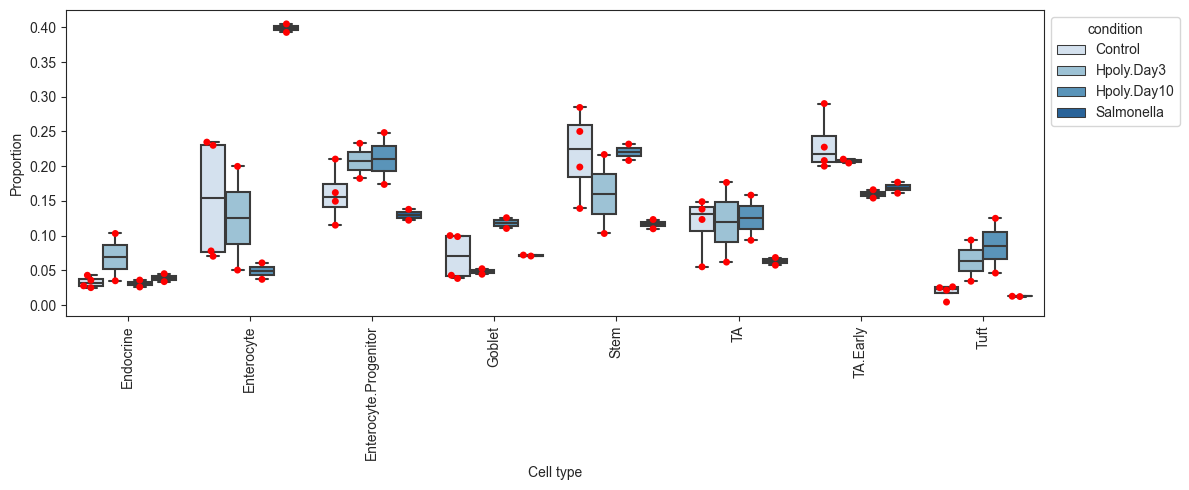

In [23]:
scc_viz.boxplots(scc_df, feature_name="condition", figsize=(12, 5), add_dots=True, args_swarmplot={"palette": ["red"]})
plt.show()

The boxplots highlight some differences in the distributions of the cell types. Clearly noticable is the high proportion of enterocytes for the Salmonella condition. But other cell types such as transit-amplifying (TA) cells also show stark differences in abundance for the Salmonella condition compared to control. Whether any of these differences are statistically significant has to be properly evaluated.

An alternative visualization is a stacked barplot as provided by scCODA. This visualization nicely displays the characteristics of compositional data: If we compare the Control and Salmonella groups, we can see that the proportion of Enterocytes greatly increases in the infected mice. Since the data is proportional, this leads to a decreased share of all other cell types to fulfil the sum-to-one constraint.

<AxesSubplot:title={'center':'condition'}, ylabel='Proportion'>

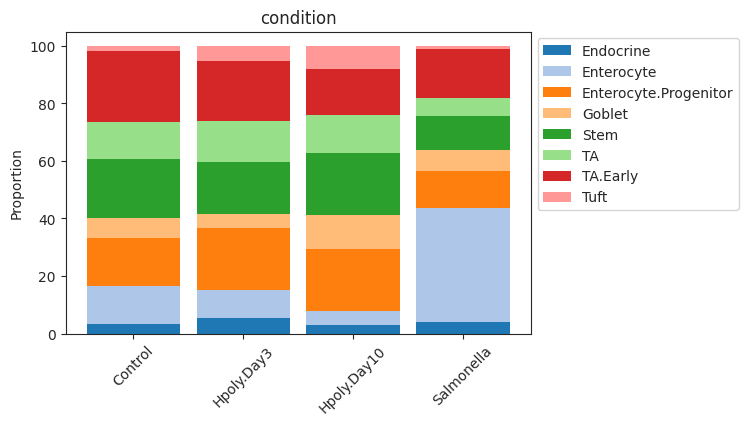

In [11]:
scc_viz.stacked_barplot(scc_df, feature_name="condition")

scCODA requires two major parameters beyond the cell count AnnData object: A formula and a reference cell type. The formula describes the covariates, which are specified using the [R-style](https://www.statsmodels.org/stable/example_formulas.html). In our case we specify the condition and the batches as independent covariates.
As mentioned above, scCODA requires a reference cell type to compare against, which is believed to be unchanged by the covariates. scCODA can either automatically select an appropriate cell type as reference, which is a cell type that has nearly constant relative abundance over all samples, or be run with a user specified reference cell type. Here we set Endocrine cells as reference cell types since visually their abundance seems to be rather constant. An alternative to setting a reference cell type manually is to set the `reference_cell_type` to `"automatic"` which will force scCODA to select a suitable reference cell type itself. If the choice of reference cell type is unclear, we recommend to use this option to get an indicator or even a final selection.

In [24]:
sccoda_mod = scc_ana.CompositionalAnalysis(
        scc_df,
        formula="condition",
        reference_cell_type="Endocrine",
    )
sccoda_res = sccoda_mod.sample_hmc(num_results=20000)

100%|██████████| 20000/20000 [00:56<00:00, 356.15it/s]


MCMC sampling finished. (71.946 sec)
Acceptance rate: 53.6%


The acceptance rate describes the fraction of proposed samples that are accepted in a window of the last N samples, and can be an ad-hoc indicator for a bad optimization run. In the case of scCODA, the desired acceptance rate is between 0.4 and 0.9. Acceptance rates that are way higher or too low indicate issues with the sampling process.

In [25]:
sccoda_res

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

scCODA selects credible effects based on their inclusion probability. The cutoff between credible and non-credible effects depends on the desired false discovery rate (FDR). A smaller FDR value will produce more conservative results, but might miss some effects, while a larger FDR value selects more effects at the cost of a larger number of false discoveries.
The desired FDR level can be easily set after inference via sim_results.set_fdr(). Per default, the value is 0.05. Since, depending on the dataset, the FDR can have a major influence on the result, we recommend to try out different FDRs up to 0.2 to get the most prominent effects.

In our case, we use less strict FDR of 0.2.

In [32]:
sccoda_res.set_fdr(0.2)

To get the binary classification of compositional changes per cell type we use the `credible_effects` function of scCODA on the result object. Every cell type labeled as "True" is significantly more or less present. The fold-changes describe whether the cell type is more or less present. Hence, we will plot them alongside the binary classification below.

In [33]:
sccoda_res.credible_effects()

Covariate                 Cell Type            
condition[T.Hpoly.Day10]  Endocrine                False
                          Enterocyte                True
                          Enterocyte.Progenitor    False
                          Goblet                   False
                          Stem                     False
                          TA                       False
                          TA.Early                 False
                          Tuft                      True
condition[T.Hpoly.Day3]   Endocrine                False
                          Enterocyte               False
                          Enterocyte.Progenitor    False
                          Goblet                   False
                          Stem                     False
                          TA                       False
                          TA.Early                 False
                          Tuft                     False
condition[T.Salmonella]   Endocrine     

To be able to easily plot the fold changes together with the binary classification, we create intermediate objects for all conditions.
1. Pandas DataFrames which only store the cell types and whether they had significant compositional changes
2. Pandas DataFrames which have the cell types as indices and the scCODA learned metrics as values.

In [34]:
credible_effects_salmonella = sccoda_res.credible_effects()["condition[T.Salmonella]"]
credible_effects_hpoly_day3 = sccoda_res.credible_effects()["condition[T.Hpoly.Day3]"]
credible_effects_hpoly_day10 = sccoda_res.credible_effects()["condition[T.Hpoly.Day10]"]

In [35]:
salmonella_effect = sccoda_res.effect_df.loc["condition[T.Salmonella]"]
hpoly_effect_3 = sccoda_res.effect_df.loc["condition[T.Hpoly.Day3]"]
hpoly_effected_10 = sccoda_res.effect_df.loc["condition[T.Hpoly.Day10]"]

salmonella_effect

,Final Parameter,HDI 3%,HDI 97%,SD,Inclusion probability,Expected Sample,log2-fold change
Cell Type,,,,,,,
Endocrine,0.000000,0.000,0.000,0.000,0.000000,32.715280,-0.523512
Enterocyte,1.531845,0.984,2.038,0.277,1.000000,382.101764,1.686472
Enterocyte.Progenitor,0.000000,-0.439,0.578,0.150,0.294200,125.944616,-0.523512
Goblet,0.000000,-0.363,0.977,0.271,0.374600,53.241718,-0.523512
Stem,0.000000,-0.701,0.339,0.174,0.325467,135.618020,-0.523512
TA,0.000000,-0.848,0.368,0.221,0.349467,78.952172,-0.523512
TA.Early,0.000000,-0.254,0.719,0.160,0.266933,152.756058,-0.523512
Tuft,0.000000,-1.397,0.479,0.347,0.364067,22.870372,-0.523512


Inspired by plots from "High-resolution single-cell atlas reveals diversity and plasticity of tissue-resident neutrophils in non-small cell lung cancer"{cite}`Salcher2022`, we can now easily filter by the cell types that had credible changes and show their log fold changes. This is easily done with the plotting library [Altair](https://altair-viz.github.io/).

In [38]:
(
    alt.Chart(
        salmonella_effect
        .loc[credible_effects_salmonella]
        .reset_index(),
        title="Salmonella",
    )
    .mark_bar()
    .encode(
        x=alt.X("Cell Type", sort="y"),
        y="log2-fold change",
        color=alt.Color("Cell Type"),
    )
    | alt.Chart(
        hpoly_effect_3
        .loc[credible_effects_hpoly_day3]
        .reset_index(),
        title="Heligmosomoides polygyrus day 3",
    )
    .mark_bar()
    .encode(
        x=alt.X("Cell Type", sort="y"),
        y="log2-fold change",
        color=alt.Color("Cell Type"),
    )
    | alt.Chart(
        hpoly_effected_10
        .loc[credible_effects_hpoly_day10]
        .reset_index(),
        title="Heligmosomoides polygyrus day 10",
    )
    .mark_bar()
    .encode(
        x=alt.X("Cell Type", sort="y"),
        y="log2-fold change",
        color=alt.Color("Cell Type"),
    )
).resolve_scale(y="shared", color="shared")

alt.HConcatChart(...)

The plots nicely show the significant and credible effects of conditions on the cell types. These effects largely agree with the findings in the Haber paper, who used a non-compositional Poisson regression model their findings:

1. "After Salmonella infection, the frequency of mature enterocytes increased substantially."{cite}`Haber2017`
2. "Heligmosomoides polygyrus caused an increase in the abundance of goblet and tuft cells."{cite}`Haber2017`

Readers familiar with the original publication probably wonder why the model used by Haber et al. found more significant effects than scCODA, for example a decrease in stem and transit-amplifying cells in the case of Salmonella infection{cite}`Haber2017`. To explain this discrepancy, remember that cell count data is compositional and therefore an increase in the relative abundance of one cell type will lead to a decrease in the relative abundance of all other cell types.
Due to the stark increase of Enterocytes in the small intestinal epithelium of Salmonella-infected mice, all other cell types appear to decrease, even though this shift is only caused by the compositional properties of the data. While the Poisson regression model will pick up these likely false positive effects, scCODA is able to account for the compositionality of the data and therefore not fall into this trap.

## Without labeled clusters

It is not always possible to obtain precise labeled clusters such as cell-type definitions, especially when the clustering boundaries are deceptive, such as during developmental processes. In such cases, determining compositional changes based on known annotations may not be appropriate. DA-seq uses a low dimensional transformation such as PCA to calculate a k-nearest neighbor graph (KNN) which is used to compute a density in the form of score vectors for each cell to group these cells into differentially abundant subpopulations{cite}`Zhao2021`. MILO assigns cells to partially overlapping neighborhoods on a KNN graph to perform differential abundance (DA) testing{cite}`Dann2022`. Both KNN-based methods are sensitive to a loss of information if the conditions of interest and confounders, defined by technical or experimental sources of variation, are strongly correlated. A fundamental limitation of KNN-based methods is that cells in a neighborhood may not necessarily represent a specific, unique biological subpopulation, because a cellular state may span over multiple neighborhoods. Reducing k for the KNN graph or constructing a graph on cells from a particular lineage of interest mitigates this issue{cite}`Dann2022`. Generally, if large differences are apparent in large clusters by visualization or a specific cell-type is of interest, KNN based methods might be ill-suited and a more direct analysis with cell-type aware methods might be a more promising option. Alternatively, quantification of perturbation effects on the level of single-cells is possible with MELD, which calculates a relative likelihood estimate of observing each cell in every condition using graph signaling{cite}`Burkhardt2021`. The determined likelihood estimate can then be used to identify cell populations that were specifically affected by a perturbation.

We will now apply MILO to the Haber dataset to try to find over- or underrepresented neighborhoods.

MILO is available as [miloR](https://github.com/MarioniLab/miloR) for R users and [milopy](https://github.com/emdann/milopy) for Python users in the scverse ecosystem. In the following demonstrate we will use milopy which is easiest to use with our AnnData object due to its scverse compatibility. Be aware that milopy in its current state also requires a working [edgeR](https://bioconductor.org/packages/release/bioc/html/edgeR.html) installation.

First, we import milopy.

In [19]:
import milopy
import milopy.core as milo

TODO: REASONING WHY PCA AND NEIGHBORS FROM LOG COUNTS

In [20]:
# use logcounts to calculate PCA and neighbors
adata.layers['counts'] = adata.X.copy()
adata.layers["logcounts"] = sc.pp.log1p(adata.layers['counts']).copy()
adata.X = adata.layers['logcounts'].copy()

TODO: https://github.com/emdann/milopy/blob/master/notebooks/milopy_example.ipynb USES THE SAME K ACROSS NEIGHBORS AND MILOPY. GUESS WE SHOULD ALSO DO THIS?
EXPLAIN WHAT WE ARE DOING HERE BRIEFLY. CALCULATING BLA AND VISUALZING BLUB. ALSO EXPLAIN THE BATCH EFFECT ISSUE THAT YOU HAD EARLIER AND HOW TO MITIGATE IT. DO WE NEED SCVI CORRECTION HERE?

TODO: NO PCA BEFORE RUNNING NEIGHBORS WHEN USING MILO? 

In [21]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [22]:
sc.tl.umap(adata)

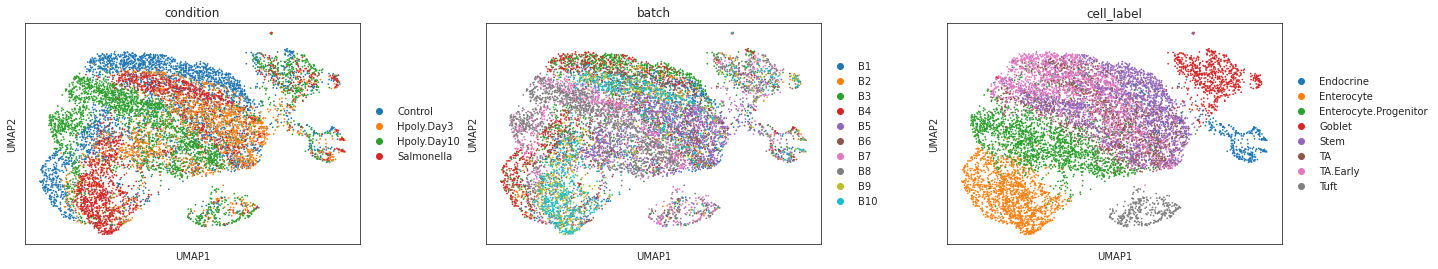

In [23]:
sc.pl.umap(adata, color=['condition', 'batch', 'cell_label'], ncols=3, wspace=0.25)

TODO: ADD COMMENT ON BATCH EFFECT CORRECTION. REQUIRED ALREADY?

MILO is a KNN-based model to test for differential abundance and therefore operates on neighborhoods of cells. Hence, we first we need to create these neighborhoods. We note that MILO uses the neighbours from `.uns['neighbors']`. Therefore, ensure that `sc.pp.neighbors` was run on the correct represenation, i.e. an integrated latent space if batch correction was required.

In [24]:
milo.make_nhoods(adata)

In the next step, MILO counts cells belonging to each of the conditions taking into account that cells come from different batches.

In [ ]:
milo.count_nhoods(adata, sample_col="batch")

Finally, MILO uses edgeR's QLF test to test if there are statistically significant differences between the number of cells from each condition in each neighborhood.

In [26]:
milo.DA_nhoods(adata, design="~ condition")

The final DA for each cell is calculated as the mean DA of all neighborhoods that the cell belongs to. We obtain DA results on the single-cell level.

In [27]:
milo_results = adata.uns["nhood_adata"].obs
milo_results

,index_cell,kth_distance,logFC,logCPM,F,PValue,FDR,SpatialFDR
0,B1_AAACGCACTGTCCC_Control_Stem,5.204549,-5.806651,11.970060,3.896253,0.048448,0.137430,0.138942
1,B1_AAAGGCCTCATGAC_Control_TA.Early,8.568722,-4.212310,11.265669,3.572490,0.058801,0.152096,0.154185
2,B1_AACCAGTGTTTCGT_Control_TA,5.801365,-4.768750,11.517511,3.833202,0.050301,0.139089,0.140793
3,B1_AAGTGCACACGTAC_Control_Stem,5.837218,-3.100849,12.017406,1.523388,0.217164,0.382623,0.377106
4,B1_AATAACACGGCAAG_Control_TA,7.075296,-5.093514,11.429176,4.530634,0.033341,0.133048,0.134970
...,...,...,...,...,...,...,...,...
846,B10_TTAACCACGACAGG_Salmonella_Enterocyte,5.903394,5.664716,11.307082,8.069511,0.004519,0.095743,0.080842
847,B10_TTACGACTGCAAGG_Salmonella_Enterocyte,5.875281,5.739043,11.382824,7.787859,0.005279,0.095743,0.080842
848,B10_TTATCCGATCCTAT_Salmonella_TA.Early,8.265007,3.444163,11.362900,3.642756,0.056370,0.148977,0.151066
849,B10_TTCACAACGGATCT_Salmonella_Goblet,10.840036,1.935549,11.162940,1.154943,0.282568,0.456176,0.449742


TODO: SO YEAH WHAT DO ALL OF THOSE VALUES MEAN? ESPECIALLY SPATIALFDR NEEDS A COMMENT.

We can also visualize the DA results on a UMAP to assess which cell types may be most affected by the disease.

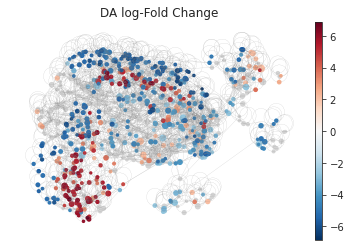

In [28]:
milopy.utils.build_nhood_graph(adata)
milopy.plot.plot_nhood_graph(adata, alpha=0.5, min_size=5, plot_edges=True)

TODO: WHAT DO I SEE? WHAT IS THE EFFECT OF THOSE PARAMETERS?

In case there are different numbers of cells for each of the conditions, we recommend to look at neighborhood MA plot to see if data is distributed around 0. For more details, please read: (https://github.com/MarioniLab/miloR/issues/208)

In [29]:
def plot_nhood_MA(adata, alpha=0.05, mean=0):
    df = adata.uns["nhood_adata"].obs
    # max_lfc = max(abs(df['logFC']))
    # max_eps = max_lfc * 0.1
    emp_null = df[df['SpatialFDR'] >= alpha]['logFC'].mean()
    # min_x = min(df['logCPM'])
    # minx_eps = min_x * 0.01
    # max_x = max(df['logCPM'])
    # maxx_eps = max_x * 0.01 

    df['Sig'] = df['SpatialFDR'] < alpha
    
    fig, ax = plt.subplots()
    sns.scatterplot(data=df, x="logCPM", y="logFC", hue='Sig', ax=ax)
    ax.axhline(y=mean, color='grey', linewidth=1)
    ax.axhline(y=emp_null, color='purple', linewidth=1)
    plt.show()

TODO: SHOULD WE REALLY CREATE A FUNCTION FOR THIS? WE ARE ONLY REALLY USING IT ONCE RIGHT? EXPLAIN THE PARAMETERS

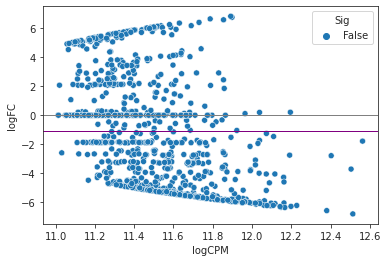

In [30]:
plot_nhood_MA(adata)

TODO: WHAT DOES THE PLOT SHOW? REFER TO COMMENTS IN https://github.com/MarioniLab/miloR/issues/208 AND EXPLAIN WHAT DO IF YOU SEE WHATEVER.

WE ONLY HAVE ONE CLASS. WHY?

TODO: ADD CONCLUSION HERE: WHAT IS DIFFERENT FROM CELL TYPE BASED? WHAT TO USE HERE? ETC

## Key Takeaways

1. If the primary interest lies in compositional changes among known cell-types or states, use scCODA or tascCODA to statistically evaluate changes in abundance.
2. KNN based methods like DA-Seq or MILO should be used if the data does not cluster distinctly, such as during developmental processes. Using MELD might be advisable if the experimental design suggests that KNN neighborhoods are unlikely to capture the perturbation source.

## Quiz

1. It is tricky to deduce compositional changes visually. Why?
2. In which cases should tools that use cluster information, such as cell types be used, and in which cases tools that do not use cluster information?